<img src="../images/aeropython_logo.png" alt="AeroPython" style="width: 300px;"/>

# Salto de Felix Baumgartner desde la estratosfera

<div style="text-align: center;">

<img src="http://undondin.com/wp-content/uploads/2013/01/red-bull-stratos.jpg" width="800" />

<p></p>

<p style="font-size: 1.5em; font-style: italic; text-align: center; line-height: 1.2em;">El 14 de octubre de 2012 Felix Baumgartner saltó de una sonda estratosférica a casi 40000 metros, batiendo los récords de vuelo en globo tripulado a mayor altura y salto a mayor altura. **¿Rompió además la barrera del sonido?**</p>

<p style="font-size: 1.5em; font-style: italic; text-align: center; line-height: 1.2em;">¡**Python**! ;)</p>
</div>

Inspiración: http://pybonacci.wordpress.com/2012/10/15/el-salto-de-felix-baumgartner-en-python/

La ecuación que gobierna la caída de Felix es:

$$\displaystyle m \frac{d^2 y}{d t^2} = -m g + D$$

Siendo

$$D = \frac{1}{2} \rho v^2 C_D A$$

donde

* $m$ es la masa de Félix y la tomaremos $m = 80~\text{kg}$,
* $\rho$ es la densidad del aire **y depende de la altura**,
* $v = |\dot{y}|$ es la velocidad,
* $C_D$ es el coeficiente de rozamiento, que tomaremos* $C_D = 0.4$, y
* $A$ es un área de referencia y tomaremos $A = 1~\text{m}^2$.

\* <small>Fuente: http://fisicadepelicula.blogspot.com.es/2012/10/la-fisica-del-salto-baumgartner.html</small>

Además, necesitaremos la altura inicial $h_0 = 39000~\text{m}$.

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Atmósfera estándar

Necesitamos escribir funciones que nos den las condiciones en la atmósfera estándar.

$$T(h) = \begin{cases} T_0 + \lambda h & 0 <= h <= 11000 \\ T(11000) & 11000 < h \end{cases}
\\ ~\\ T_0 = 288.16 K \\
\lambda = -6.5 \cdot 10^{-3}~\text{K/m}$$

In [3]:
def T_ISA(h):
    """Temperatura en función de la altitud según modelo ISA.

    Argumentos
    ----------
    h : Altura en metros.

    Devuelve
    --------
    T : Temperatura en Kelvin.

    """
    T0 = 288.16  # K
    ll = -6.5e-3  # K / m
    if 0 <= h <= 11000:
        T = T0 + ll * h
    elif 11000 < h:
        T = T0 + ll * 11000
    # Es preferible que la función tenga solo un `return`
    return T

In [4]:
help(T_ISA)

Help on function T_ISA in module __main__:

T_ISA(h)
    Temperatura en función de la altitud según modelo ISA.
    
    Argumentos
    ----------
    h : Altura en metros.
    
    Devuelve
    --------
    T : Temperatura en Kelvin.



Si quieres comprobar que tus funciones hacen lo que deben, puedes ejecutar estos tests:

In [5]:
from numpy.testing import assert_almost_equal

assert_almost_equal(T_ISA(0), 288.16)
assert_almost_equal(T_ISA(11000), 216.66)

<div class="alert alert-warning">**¡Importante!** Si utilizas condicionales para comprobar las capas de la atmósfera, seguramente tus funciones fallarán si las quieres representar utilizando un `linspace`. Para estos casos es mejor utilizar la función `np.select`:</div>

In [6]:
def T_ISA(h):
    """Temperatura en función de la altitud según modelo ISA.

    Argumentos
    ----------
    h : Altura en metros.

    Devuelve
    --------
    T : Temperatura en Kelvin.

    """
    # Con esta línea convertimos la entrada a un array
    h = np.asarray(h)

    T0 = 288.16  # K
    ll = -6.5e-3  # K / m

    T1 = T0 + ll * h
    T2 = T0 + ll * 11000

    # 0 <= h <= 110000 no funciona para arrays
    T = np.select([(0 <= h) & (h <= 11000), 11000 < h], [T1, T2])
    return T

In [7]:
T_ISA(0)

array(288.16)

In [8]:
T_ISA(np.array([0, 11000, 20000]))

array([ 288.16,  216.66,  216.66])

In [9]:
# Como hemos puesto `h = np.asarray(h)`, podemos hacer esto
T_ISA([0, 11000, 20000])

array([ 288.16,  216.66,  216.66])

Otra forma alternativa (idea de Alfredo y Laura):

In [10]:
def T_ISA(h):
    """Temperatura en función de la altitud según modelo ISA.

    Argumentos
    ----------
    h : Altura en metros.

    Devuelve
    --------
    T : Temperatura en Kelvin.

    """
    # Con esta línea convertimos la entrada a un array
    h = np.atleast_1d(h)

    T0 = 288.16  # K
    ll = -6.5e-3  # K / m

    T = np.zeros_like(h, dtype=float)

    T[(0 <= h) & (h <= 11000)] = T0 + ll * h[(0 <= h) & (h <= 11000)]
    T[11000 < h] = T0 + ll * 11000

    return T

In [11]:
T_ISA(0)

array([ 288.16])

In [12]:
T_ISA([0, 11000, 20000])

array([ 288.16,  216.66,  216.66])

$$ \rho(h) = \begin{cases} \rho_0 \left( \frac{T}{T_0} \right)^{-\frac{g}{\lambda R} - 1} & 0 <= h <= 11000 \\ \rho(11000)~e^{\frac{-g(z - 11000)}{R T}} & 11000 < h <= 20000 \end{cases} $$

$$\rho_0 = 1.225~\text{[SI]} \\
R = 287~\text{[SI]}$$

In [13]:
def rho_ISA(h):
    h = np.asarray(h)

    T0 = 288.16  # K
    ll = -6.5e-3  # K / m
    g = 9.8  # m / s2
    rho0 = 1.225  # kg / m3
    R = 287.0  # [SI]

    rho1 = rho0 * (T_ISA(h) / T0) ** (-g / (ll * R) - 1)
    # ¿Habrá otra manera de hacerlo sin este copia-pega?
    rho2 = rho0 * (T_ISA(11000) / T0) ** (-g / (ll * R) - 1) * np.exp(-g * (h - 11000) / (R * T_ISA(h)))

    rho = np.select([(0 <= h) & (h <= 11000), 11000 < h], [rho1, rho2])
    return rho

In [14]:
rho_ISA([0, 11000, 20000])

array([ 1.225     ,  0.36420497,  0.08817176])

## Ecuación diferencial

Recuerda de la clase 4b que `integrate.odeint` resuelve ecuaciones del tipo:

$$ \frac{d\mathbf{y}}{dt}=\mathbf{f}\left(\mathbf{y},t\right)$$

con condiciones iniciales $\mathbf{y}(\mathbf{0}) = \mathbf{y_0}$. Por tanto, y al tratarse esta de una ecuación en derivada segunda, hay que hacer una reducción de orden.

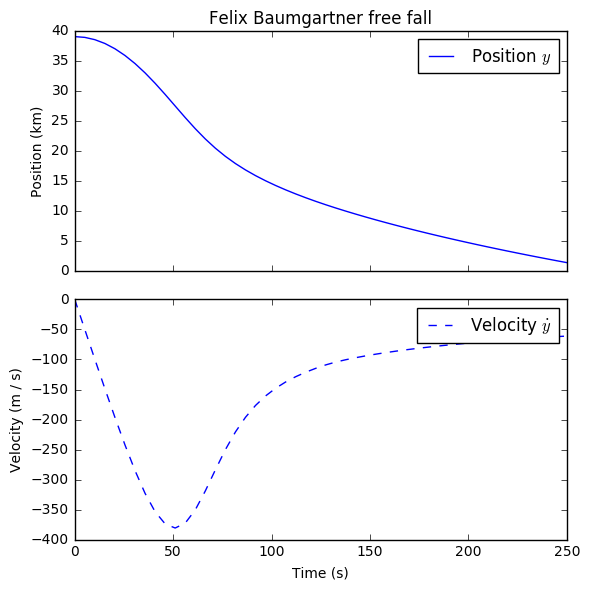

In [15]:
from scipy import integrate
%matplotlib inline
import matplotlib.pyplot as plt

# Función del sistema
def f(y, t):
    g = 9.8  # m / s2
    C_D = 0.4
    A = 1.0  # m^2
    m = 80  # kg
    return np.array([
        y[1],
        -g + rho_ISA(y[0]) * y[1] ** 2 * C_D * A / (2 * m)
    ])

# Condiciones iniciales
y0 = np.array([39000, 0])

# Vector de tiempos
t = np.linspace(0, 250)

# Integramos la ecuación
sol = integrate.odeint(f, y0, t)

pos = sol[:, 0]  # Primera columna: posición
vel = sol[:, 1]  # Segunda columna: velocidad

# Representamos la solución
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
line, = axes[0].plot(t, pos / 1e3, label="Position $y$")
axes[0].set_ylabel("Position (km)")
axes[1].plot(t, vel, '--', color=line.get_color(), label="Velocity $\dot{y}$")
axes[1].set_ylabel("Velocity (m / s)")
axes[1].set_xlabel("Time (s)")
axes[0].legend()
axes[1].legend()
axes[0].set_title("Felix Baumgartner free fall")
fig.tight_layout()

## Barrera del sonido

La velocidad del sonido en el aire variará también, y lo hará de esta forma:

$$M = \frac{v}{c}$$

siendo

$$c = \sqrt{\gamma R T}$$

Como paso final, representa $M$ en función de $t$ y en la misma gráfica incluye una línea horizontal de trazo discontinuo donde $M = 1$.

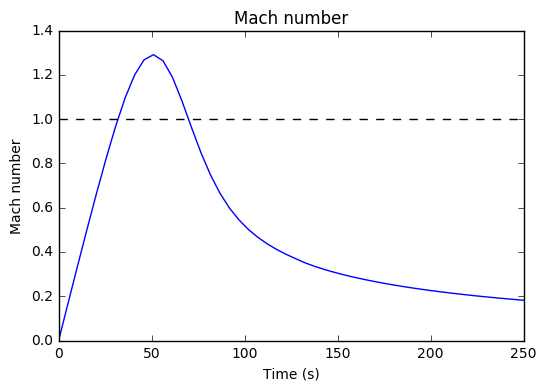

In [16]:
gamma = 1.4
R = 287.0  # [SI]
c = np.sqrt(gamma * R * T_ISA(pos))

M = np.abs(vel) / c

plt.plot(t, M)
plt.plot(t, np.ones_like(t), 'k--')
plt.ylabel('Mach number')
plt.xlabel('Time (s)')
plt.title("Mach number")

**Barrera del sonido superada** ;)

---

#### <h4 align="right">¡Síguenos en Twitter!
<br/>
###### <a href="https://twitter.com/AeroPython" class="twitter-follow-button" data-show-count="false">Follow @AeroPython</a> <script>!function(d,s,id){var js,fjs=d.getElementsByTagName(s)[0],p=/^http:/.test(d.location)?'http':'https';if(!d.getElementById(id)){js=d.createElement(s);js.id=id;js.src=p+'://platform.twitter.com/widgets.js';fjs.parentNode.insertBefore(js,fjs);}}(document, 'script', 'twitter-wjs');</script> 
<br/>
###### Este notebook ha sido realizado por: Juan Luis Cano
<br/>
##### <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es"><img alt="Licencia Creative Commons" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Curso AeroPython</span> por <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Juan Luis Cano Rodriguez y Alejandro Sáez Mollejo</span> se distribuye bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/deed.es">Licencia Creative Commons Atribución 4.0 Internacional</a>.

---
_Las siguientes celdas contienen configuración del Notebook_

_Para visualizar y utlizar los enlaces a Twitter el notebook debe ejecutarse como [seguro](http://ipython.org/ipython-doc/dev/notebook/security.html)_

    File > Trusted Notebook

In [17]:
# Esta celda da el estilo al notebook
from IPython.core.display import HTML
css_file = '../styles/aeropython.css'
HTML(open(css_file, "r").read())